In this code example, we'll apply LQR feedback control to stabilize a 2D quadrotor along a trajectory.

In [ ]:
%pylab inline
from pylab import *

import control
import matplotlib.animation
import scipy.interpolate

rc("animation", html="html5")

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.curve_utils       as curve_utils
import flashlight.interpolate_utils as interpolate_utils
import flashlight.quadrotor_2d      as quadrotor_2d
import flashlight.spline_utils      as spline_utils
import flashlight.trig_utils        as trig_utils

We begin by computing our intended trajectory exactly as in the previous examples.

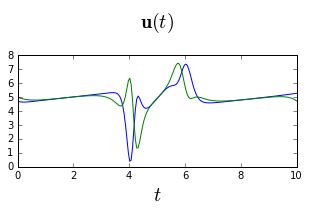

In [15]:
T_y = matrix([0,1,2,3]).T.A
T_x = matrix([0,1,2,3]).T.A
T   = c_[T_y, T_x]
P_y = matrix([0,3,1,4]).T.A
P_x = matrix([0,3,7,10]).T.A
P   = c_[P_y, P_x]

num_samples = 200

C, T, sd = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])
    
P_eval, T_eval, dT = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd, num_samples=num_samples)

T_s = matrix([0.0,1.2,1.8,3.0]).T.A
P_s = matrix([0.0,0.3,0.7,1.0]).T.A

C_s, T_s, sd_s = \
    spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P_s, T_s, degree=7, lamb=[0,0,0,1,0])
    
P_s_eval, T_s_eval, dT_s = \
    spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C_s, T_s, sd_s, num_samples=num_samples)

t = linspace(0.0,10.0,num_samples)
s_nonlinear = P_s_eval

P_eval_nonlinear, t_nonlinear, P_eval_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s_nonlinear)

t_begin       = t[0]
t_end         = t[-1]
num_timesteps = num_samples

p  = P_eval_nonlinear
dt = (t_end-t_begin) / num_timesteps

q_qdot_qdotdot = quadrotor_2d.compute_state_space_trajectory_and_derivatives(p, dt)
u              = quadrotor_2d.compute_control_trajectory(q_qdot_qdotdot)

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);

Next, we set up our simulation callback function to compute the appropriate control forces and compute the time derivative of our quadrotor state.

Our time-varying LQR control strategy here is similar to the control strategy in our previous code example. However, in this code example, our linearization point varies with time. Instead of linearizing about hovering-at-the-origin, we linearize about our intended trajectory. For more details on time-varying LQR, see [1].

Notice how applying time-varying LQR completely eliminates the drift away from our intended trajectory, which was an issue in our previous code example.

#### References

[1] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (course notes for MIT 6.832). 2016. http://underactuated.mit.edu

In [16]:
x_nominal = quadrotor_2d.pack_state_space_trajectory_and_derivatives(q_qdot_qdotdot)
u_nominal = u

x_0 = x_nominal[0]

Q = diag([1,1,1,1,1,1])
R = diag([1,1])

def compute_x_dot(x_t, t):

    x_t = matrix(x_t).T
    
    x_nominal_t = x_nominal_interp_func(clip(t, t_begin, t_end))
    u_nominal_t = u_nominal_interp_func(clip(t, t_begin, t_end))
    
    A_t, B_t      = quadrotor_2d.compute_df_dx_and_df_du(x_nominal_t, u_nominal_t)
    K_t, S_t, E_t = control.lqr(A_t, B_t, Q, R)
    
    x_bar_t = x_t - x_nominal_t
    u_bar_t = -K_t*x_bar_t
    u_t     = u_bar_t + u_nominal_t
    x_dot_t = quadrotor_2d.compute_x_dot(x_t, u_t).A1
    
    return x_dot_t

num_timesteps_sim     = 200
t_sim                 = linspace(t_begin, t_end, num_timesteps_sim)
u_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, u_nominal, kind="cubic")
x_nominal_interp_func = interpolate_utils.interp1d_vector_wrt_scalar(t, x_nominal, kind="cubic")
x_sim                 = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

figsize(9,4)
quadrotor_2d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, return_anim_func=True)

Finally, we specify our initial state to be some distance away from our intended trajectory, with a large initial velocity, to simulate a large unexpected disturbance at the beginning of the simulation. Notice how applying time-varying LQR successfully attracts the quadrotor back to our intended trajectory.

In [19]:
x_disturbance = array([-2.0, -2.0, pi/4.0, 5.0, -5.0, -4.0*pi])
x_0           = x_nominal[0] + x_disturbance
x_sim         = scipy.integrate.odeint(compute_x_dot, x_0, t_sim)

figsize(9,4)
quadrotor_2d.draw(t_sim, x_sim, t_nominal=t, x_nominal=x_nominal, return_anim_func=True)